In [1]:
# import bw2io as bi

In [2]:
# bi.restore_project_directory('/Users/timodiepers/Documents/Coding/brightway2-project-bw25_premise_background_v2-backup.26-March-2024-01-40PM.tar.gz', overwrite_existing=True, project_name='bw25_premise')

In [3]:
import bw2data as bd

In [4]:
bd.projects.set_current('bw25_premise')

In [5]:
bd.databases

Databases dictionary with 6 object(s):
	biosphere3
	cutoff39
	db_2020
	db_2030
	db_2040
	foreground

In [6]:
db_2020 = bd.Database("db_2020")
db_2030 = bd.Database("db_2030")
db_2040 = bd.Database("db_2040")

In [7]:
del bd.databases['foreground']

In [8]:
ev_background = [x for x in db_2020 if (x['name'] == 'transport, passenger car, electric')][0]
ev_background

'transport, passenger car, electric' (kilometer, GLO, None)

In [9]:
[e for e in ev_background.exchanges()]

In [10]:
foreground = bd.Database("foreground")
foreground.write({})

In [11]:
ev = ev_background.copy(name="copy of transport, passenger car, electric")

In [12]:
ev['database'] = 'foreground'

Successfully switch activity dataset to database `foreground`


In [13]:
ev.save()

In [14]:
[e for e in ev.exchanges()]

[Exchange: 1.0 kilometer 'copy of transport, passenger car, electric' (kilometer, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -1.050395781021507e-06 kilogram 'market for brake wear emissions, passenger car' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -1.155435347754974e-05 kilogram 'market for road wear emissions, passenger car' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -0.0026199999265372753 kilogram 'market for used Li-ion battery' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -6.756759830750525e-05 kilogram 'market for tyre wear emissions, passenger car' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: 0.00048747999244369566 meter-year 'market for road' (meter-year, GLO, None) to 'copy of trans

In [15]:
from bw_temporalis import TemporalDistribution
import numpy as np

# defining Temporal Distributions of system
td_production = TemporalDistribution(
            date=np.array([-1], dtype='timedelta64[Y]'), #2023
            amount=np.array([1]))

td_use_phase = TemporalDistribution( #to be further refined based on use pattern
                    date=np.array([1, 6, 11, 16], dtype='timedelta64[Y]'), #2025, 2030, 2035, 2040
                    amount=np.array([0.25, 0.25, 0.25, 0.25]))

td_eol = TemporalDistribution(
            date=np.array([21], dtype='timedelta64[Y]'), #2045
            amount=np.array([1]))

td_eol_from_production_time = TemporalDistribution(
            date=np.array([22], dtype='timedelta64[Y]'), #2045, counting from 2023
            amount=np.array([1]))

In [16]:
#add TD to electricity and car production
for exc in ev.exchanges():
    if "market for battery, Li-ion"in exc.input["name"]: #battery production
        exc["temporal_distribution"]= td_production
        exc.save()
        print("added TD to ", {exc.input["name"]})

    elif "market for passenger car, electric, without battery"in exc.input["name"]: # foreground car production
        exc["temporal_distribution"]= td_production
        exc.save()
        print("added TD to ", {exc.input["name"]})

    elif "market group for electricity, low voltage" in exc.input["name"]: #electricity while driving
        exc["temporal_distribution"]= td_use_phase
        exc.save()
        print("added TD to ", {exc.input["name"]})

    elif "market for used Li-ion battery" in exc.input["name"]:   #battery recycling
        exc["temporal_distribution"]= td_eol
        exc.save()
        print("added TD to ", {exc.input["name"]})

    elif "wear emissions, passenger car" in exc.input["name"]: #brake, road and tyre wear while driving
        exc["temporal_distribution"]= td_use_phase
        exc.save()
        print("added TD to ", {exc.input["name"]})
    
    elif "market for maintenance, passenger car" in exc.input["name"]: #car maintenance while driving
        exc["temporal_distribution"]= td_use_phase
        exc.save()
        print("added TD to ", {exc.input["name"]})
            
    elif exc.input["name"] == "market for road": # road usage while driving
        exc["temporal_distribution"]= td_use_phase
        exc.save()
        print("added TD to ", {exc.input["name"]})
    
    elif exc.input["name"] == exc.output["name"]: #skip production exchange
        continue

    else:
        print("no TD added to ", {exc.input["name"]})

    # car recycling is modelled at the level of car production, and TD is added there

added TD to  {'market for brake wear emissions, passenger car'}
added TD to  {'market for road wear emissions, passenger car'}
added TD to  {'market for used Li-ion battery'}
added TD to  {'market for tyre wear emissions, passenger car'}
added TD to  {'market for road'}
added TD to  {'market for battery, Li-ion, LiMn2O4, rechargeable, prismatic'}
added TD to  {'market for maintenance, passenger car, electric, without battery'}
added TD to  {'market for passenger car, electric, without battery'}
added TD to  {'market group for electricity, low voltage'}


In [17]:
method = ('IPCC 2021 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

In [18]:
from datetime import datetime

database_date_dict = {
    "db_2020": datetime.strptime("2020", "%Y"),
    "db_2030": datetime.strptime("2030", "%Y"),
    "db_2040": datetime.strptime("2040", "%Y"),
    # "cutoff39": datetime.strptime("2020", "%Y"), # all databases need to have a corresponding time
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

In [19]:
from timex_lca import TimexLCA
tlca = TimexLCA({ev.key: 1}, method, None, database_date_dict) #aborted after 100 min for max_calc = 5000


Calculation count: 5


In [20]:
tlca.build_timeline()

,hash_producer,time_mapped_producer,date_producer,producer,producer_name,hash_consumer,time_mapped_consumer,date_consumer,consumer,consumer_name,amount,interpolation_weights
0,2023,98281,2023-01-01,35045,"market for battery, Li-ion, LiMn2O4, rechargea...",2024,98283,2024-01-01,98280,"copy of transport, passenger car, electric",0.00262,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
1,2023,98282,2023-01-01,43696,"market for passenger car, electric, without ba...",2024,98283,2024-01-01,98280,"copy of transport, passenger car, electric",0.006121,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
2,2024,98283,2024-01-01,98280,"copy of transport, passenger car, electric",2024,-1,2024-01-01,-1,-1,1.0,"{'db_2020': 0.6000547495209416, 'db_2030': 0.3..."
3,2025,98284,2025-01-01,31847,market for road,2024,98283,2024-01-01,98280,"copy of transport, passenger car, electric",0.000122,"{'db_2020': 0.4998631261976457, 'db_2030': 0.5..."
4,2025,98285,2025-01-01,40481,"market for maintenance, passenger car, electri...",2024,98283,2024-01-01,98280,"copy of transport, passenger car, electric",0.000002,"{'db_2020': 0.4998631261976457, 'db_2030': 0.5..."
5,2025,98286,2025-01-01,50069,"market group for electricity, low voltage",2024,98283,2024-01-01,98280,"copy of transport, passenger car, electric",0.04975,"{'db_2020': 0.4998631261976457, 'db_2030': 0.5..."
6,2030,98287,2030-01-01,31847,market for road,2024,98283,2024-01-01,98280,"copy of transport, passenger car, electric",0.000122,{'db_2030': 1}
7,2030,98288,2030-01-01,40481,"market for maintenance, passenger car, electri...",2024,98283,2024-01-01,98280,"copy of transport, passenger car, electric",0.000002,{'db_2030': 1}
8,2030,98289,2030-01-01,50069,"market group for electricity, low voltage",2024,98283,2024-01-01,98280,"copy of transport, passenger car, electric",0.04975,{'db_2030': 1}
9,2035,98290,2035-01-01,31847,market for road,2024,98283,2024-01-01,98280,"copy of transport, passenger car, electric",0.000122,"{'db_2030': 0.5, 'db_2040': 0.5}"


In [21]:
tlca.build_datapackage()
tlca.lci()
tlca.lcia()

In [22]:
bd.databases

Databases dictionary with 6 object(s):
	biosphere3
	cutoff39
	db_2020
	db_2030
	db_2040
	foreground

In [23]:
co2_flows = [flow for flow in bd.Database('biosphere3') if 'Carbon dioxide' in flow['name'] and "air" in flow['categories']]
co2_flows

['Carbon dioxide, from soil or biomass stock' (kilogram, None, ('air', 'urban air close to ground')),
 'Carbon dioxide, from soil or biomass stock' (kilogram, None, ('air',)),
 'Carbon dioxide, from soil or biomass stock' (kilogram, None, ('air', 'low population density, long-term')),
 'Carbon dioxide, fossil' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')),
 'Carbon dioxide, from soil or biomass stock' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')),
 'Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground')),
 'Carbon dioxide, non-fossil' (kilogram, None, ('air', 'low population density, long-term')),
 'Carbon dioxide, fossil' (kilogram, None, ('air',)),
 'Carbon dioxide, from soil or biomass stock' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Carbon dioxide, non-fossil' (kilogram, None, ('air', 'urban air close to ground')),
 'Carbon dioxide, non-fossil' (kilogram, None, ('air', 'non-urban air or from 

In [27]:
co2_flows_codes = [flow.key[1] for flow in co2_flows]

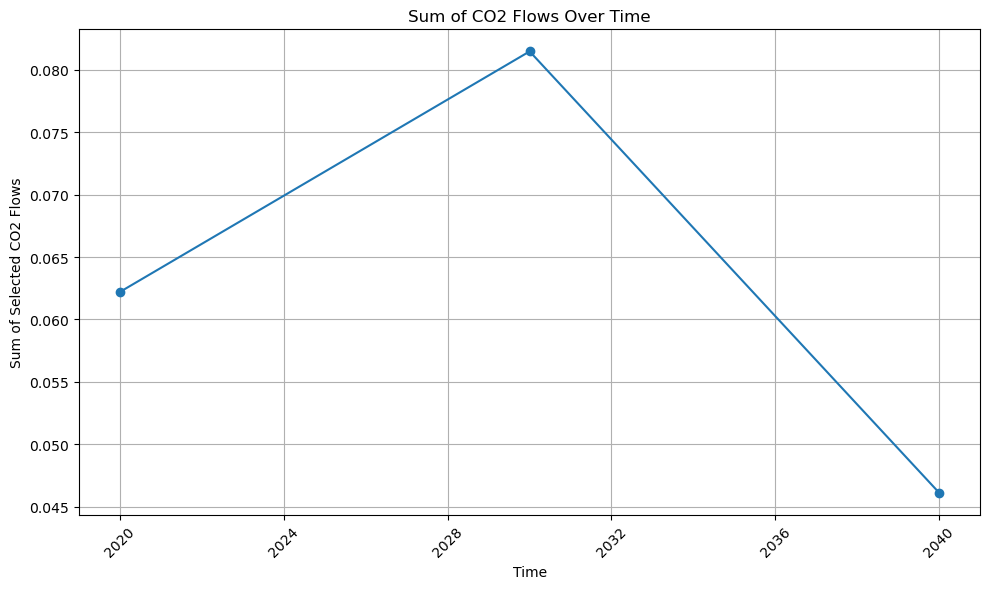

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Initialize a defaultdict to store summed amounts for each unique time point
time_amounts = defaultdict(float)

# Iterate over each specified flow and aggregate amounts by time
for flow_id in co2_flows_codes:
    if flow_id in tlca.dynamic_inventory:
        flow_data = tlca.dynamic_inventory[flow_id]
        for time, amount in zip(flow_data['time'], flow_data['amount']):
            time_amounts[str(time)] += amount  # Convert time to string for uniqueness

# Sort the times and amounts for plotting
sorted_times = np.array(sorted(time_amounts.keys()))
sorted_amounts = np.array([time_amounts[time] for time in sorted_times])

# Convert sorted times from strings back to datetime for plotting
sorted_times = np.array(sorted_times, dtype='datetime64')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sorted_times, sorted_amounts, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Sum of Selected CO2 Flows')
plt.title('Sum of CO2 Flows Over Time')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels
plt.show()